# Notebook 1. Obtaining embeddings from a movie.

In this notebook, we are going to obtain image embeddings from the frames of a movie called [(500) Days of Summer](https://www.imdb.com/title/tt1022603/).

To get the embeddings we are going to use the EfficientNet CNN (https://arxiv.org/abs/1905.11946).


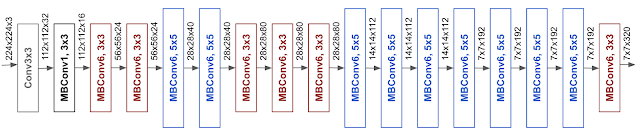

In general, the EfficientNet models achieve both higher accuracy and better efficiency over existing CNNs, reducing parameter size and FLOPS by an order of magnitude.

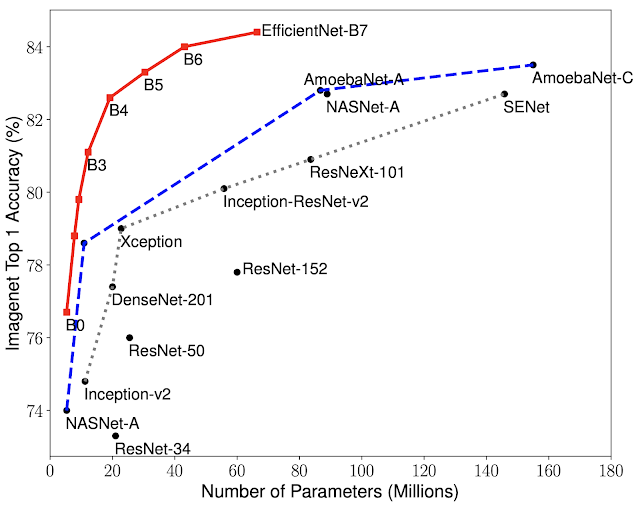





For faster training, activate a GPU or a TPU on Google Colab:

Follow Edit > Notebook settings or Runtime > Change runtime type and select GPU/TPU as Hardware accelerator.


Now we begin importing the necessary libraries.

In [ ]:
# Operating system interfaces
import os 
# Library for real-time computer vision
import cv2
# Plot library
import matplotlib.pyplot as plt
# Operations on matrices
import numpy as np
# Deep learning library
import tensorflow as tf
# Track time
import time
# Pandas table-like dataframes
import pandas as pd
# High-performance data structures library
import pyarrow.parquet as pq
import pyarrow as pa
# Plot movie frames on Google Colab
from google.colab.patches import cv2_imshow

# Install and import EfficientNet
!pip install EfficientNet
from efficientnet.tfkeras import EfficientNetB0

     |████████████████████████████████| 51kB 5.0MB/s 


We will load a clip of the movie and take a look into the first frames.

Upload the .mp4 into your Google Drive account and change the existing path below.

Mounted at /content/drive


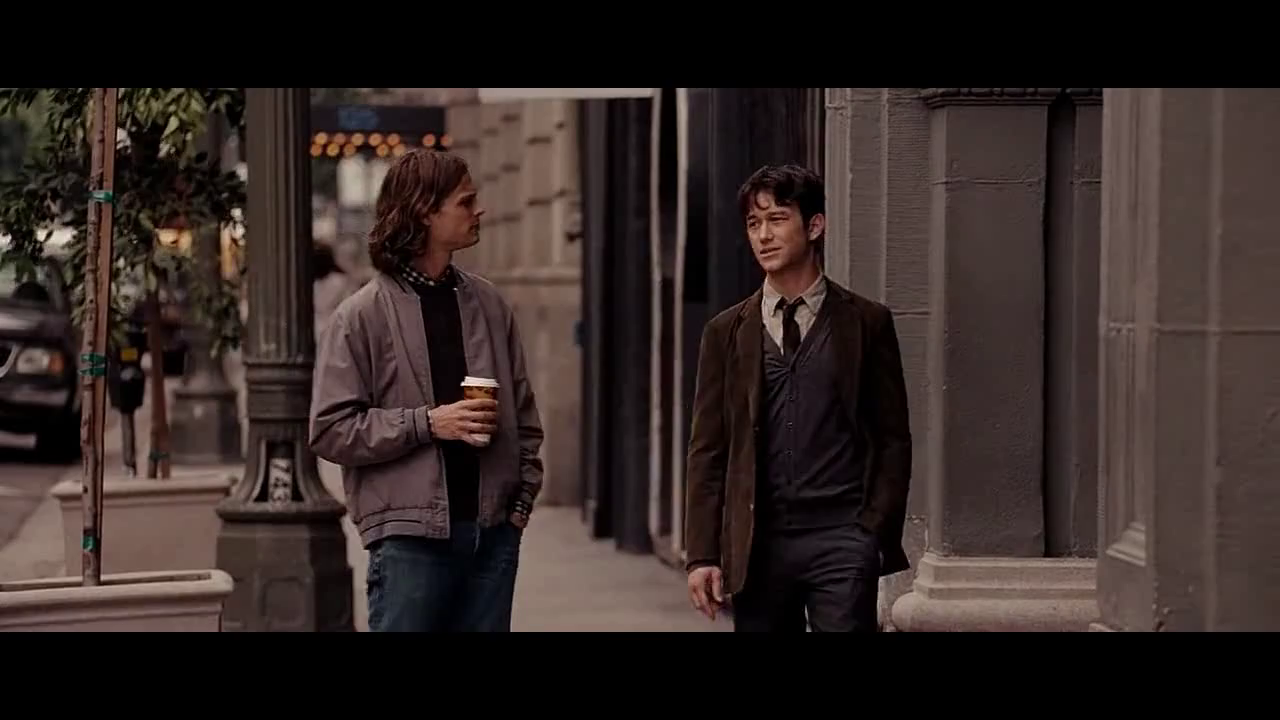

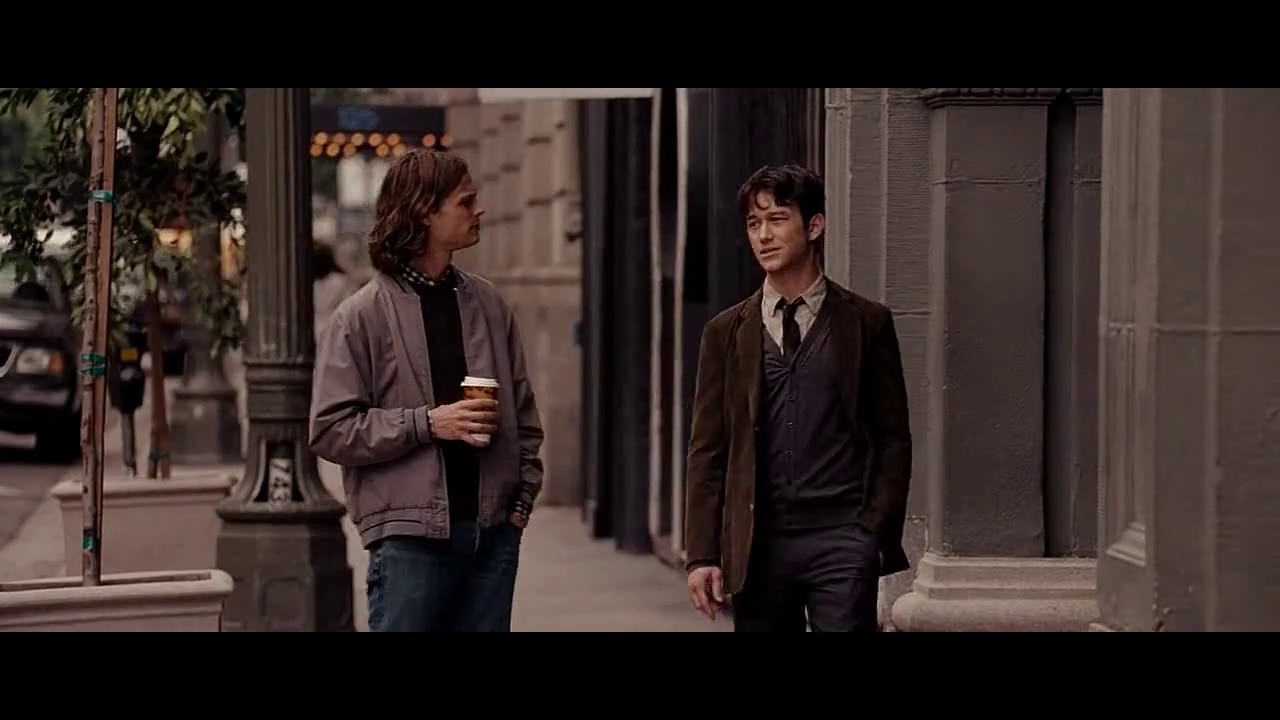

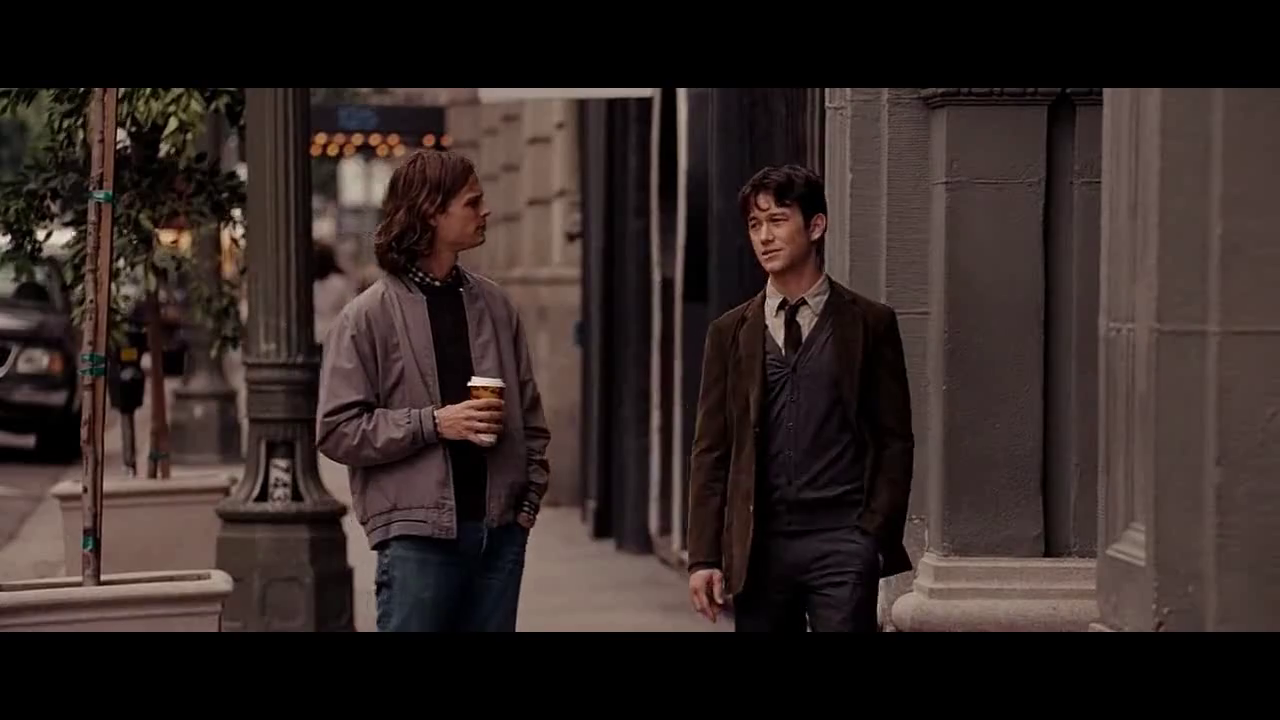

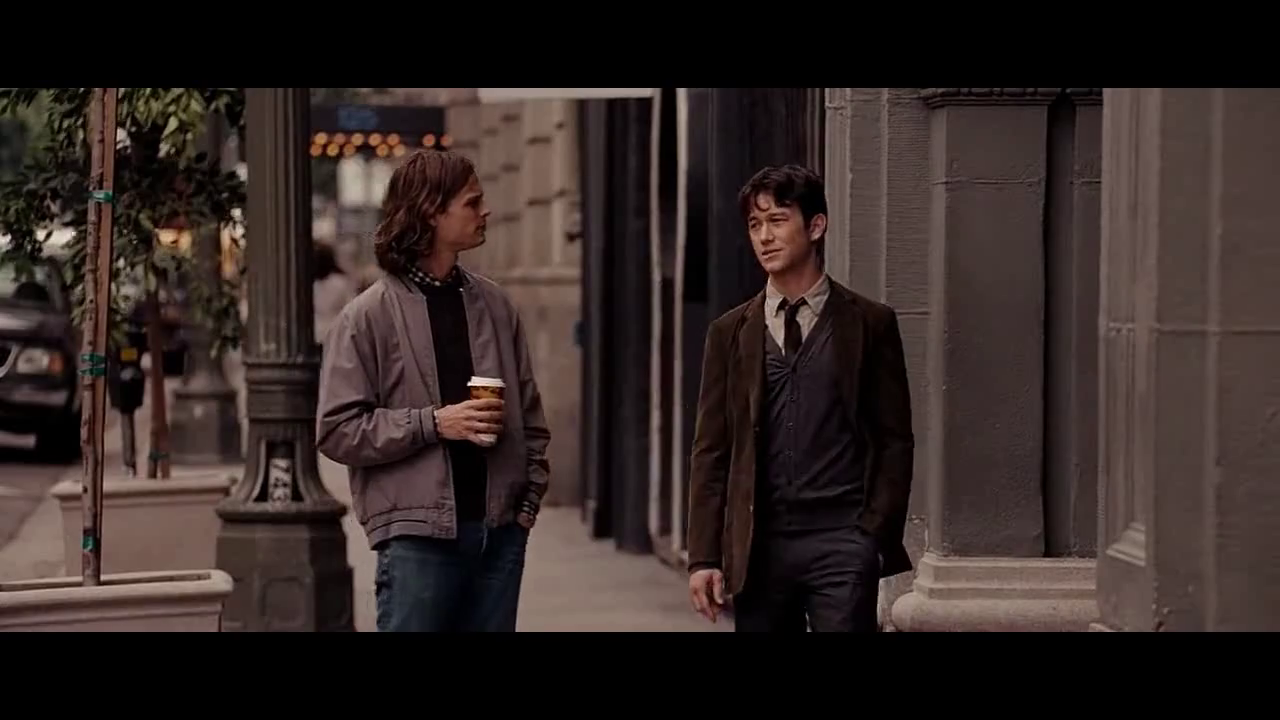

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Check the path where you uploaded the movie clip
cap = cv2.VideoCapture('/content/drive/My Drive/Trento/Data/500days.mp4')


# Initialize a variable to store five frames of (height, width, color channels) dimension
frames = np.zeros((5, 720, 1280, 3))

for n in range(1,5):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Display the resulting frame
    cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    frames[n] = frame

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Now we define the functions for our processing:

* First, we define the functions for data preprocessing.

* Then, we use TensorFlow Records to increase performance by transforming the input data into binary format.

* Finally, we run the inference to get the embeddings.

In [ ]:
# Get the files on a path
def list_files(images_path):
    return tf.data.Dataset.list_files(images_path + '/*', shuffle=False).cache()

# Obtain filenames
def process_path(file_path):
    parts = tf.strings.split(file_path, '/')
    image_name = tf.strings.split(parts[-1], '.')[0]
    raw = tf.io.read_file(file_path)
    return raw, image_name

# Read the data contained in the files
def read_data_from_files(list_ds):
    return list_ds.map(process_path,
                       num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Type conversion
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# Get image names
feature_description = {
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string)
}

# Tensor transformations for better performance
def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

def tf_serialize_example(image, image_name):
    tf_string = tf.py_function(
        serialize_example,
        (image, image_name),
        tf.string)
    return tf.reshape(tf_string, ())

# Functions to transform images to the TensorFlow Record binary format
def read_image_file_write_tfrecord(files_ds, output_filename):
    # Writes a dataset to a TFRecord file. The elements of the dataset must be scalar strings. 
    # To serialize dataset elements as strings, we use the tf_serialize_example function.
    image_ds = files_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    serialized_features_dataset = image_ds.map(tf_serialize_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    writer = tf.data.experimental.TFRecordWriter(output_filename)
    writer.write(serialized_features_dataset)

# Serialize strings
def serialize_example(image, image_name):
    feature = {
        'image_name': _bytes_feature(image_name),
        'image': _bytes_feature(image)
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Display conversion status on shard data partitions
def image_files_to_tfrecords(list_ds, output_folder, num_shard):
    start = time.time()
    for shard_id in range(0, num_shard):
        shard_list = list_ds.shard(num_shards=num_shard, index=shard_id)
        read_image_file_write_tfrecord(shard_list, output_folder + "/part-" + "{:03d}".format(shard_id) + ".tfrecord")
        print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")

# Decode the jpeg and transform to tensor
def preprocess_image(d):
    image_name = d['image_name']
    raw = d['image']
    image = tf.image.decode_jpeg(raw)
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image, image_name

# Read the TensorFlow Records
def read_tfrecord(filename):
    filenames = [filename]
    raw_dataset = tf.data.TFRecordDataset(filenames)
    return raw_dataset \
        .map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .apply(tf.data.experimental.ignore_errors())

# Write the TensorFlow Records
def write_tfrecord(image_folder, output_folder, num_shards=100):
    list_ds = list_files(image_folder)
    image_files_to_tfrecords(list_ds, output_folder, num_shards)

# Obtain the embeddings and save
def save_embeddings_ds_to_parquet(embeddings, dataset, path):
    embeddings = pa.array(embeddings.tolist(), type=pa.list_(pa.float32()))
    image_names = pa.array(dataset.map(lambda image_raw, image_name: image_name).as_numpy_iterator())
    table = pa.Table.from_arrays([image_names, embeddings], ["image_name", "embedding"])
    pq.write_table(table, path)

def compute_save_embeddings(list_ds, folder, num_shards, model, batch_size):
    start = time.time()
    for shard_id in range(0, num_shards):
        shard_list = list_ds.shard(num_shards=num_shards, index=shard_id)
        shard = read_data_from_files(shard_list)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("Shard " + str(shard_id) + " done after " + str(int(time.time() - start)) + "s")
        save_embeddings_ds_to_parquet(embeddings, shard,
                                      folder + "/part-" + "{:03d}".format(shard_id) + ".parquet")
        print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")
    print("Total time : " + str(int(time.time() - start)))

def images_to_embeddings(model, dataset, batch_size):
    return model.predict(dataset.batch(batch_size).map(lambda image_raw, image_name: image_raw), verbose=1)

def tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size):
    tfrecords = [f.numpy().decode("utf-8") for f in \
                 tf.data.Dataset.list_files(tfrecords_folder + "/*.tfrecord", shuffle=False)]
    start = time.time()
    for shard_id, tfrecord in enumerate(tfrecords):
        shard = read_tfrecord(tfrecord)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("")
        print("Shard " + str(shard_id) + " done after " + str(int(time.time() - start)) + "s")
        save_embeddings_ds_to_parquet(embeddings, shard,
                                      output_folder + "/part-" + "{:03d}".format(shard_id) + ".parquet")
        print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")

# Main function for inference to get the embeddings
def run_inference(tfrecords_folder, output_folder, batch_size):
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling="avg")
    tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size)

In this step, we are going to process the entire clip and save each frame into a folder.

The fMRI Repetition Time (sampling rate) is 1 Hz, and the clip has 30 frames per second. We will undersample the movie clip to align the timeseries for the next notebook.

In [ ]:
!rm -rf images
!mkdir images
!du -hs images

cap = cv2.VideoCapture('/content/drive/My Drive/Trento/Data/500days.mp4')

path = '/content/images'


for i in range(0,int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), int(cap.get(cv2.CAP_PROP_FPS))):
  
    ret, frame = cap.read()

    # Resize the 1280 x 720 resolution frames to 398 x 224 (to maintain ratio)
    # Then clip the frames to get 224 x 224 CNN inputs

    dim = (398, 224)

    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    crop_img = resized[: , int(87):int(311)]

    if ret == False:
        break
    cv2.imwrite(os.path.join(path, str(i) +'.jpg'), crop_img)
 
cap.release()
cv2.destroyAllWindows()

4.0K	images


Now we write the TensorFlow Records.

In [ ]:
!rm -rf tfrecords
!mkdir tfrecords
!du -h -s tfrecords

write_tfrecord("images", "tfrecords", 1)

4.0K	tfrecords
Shard 0 saved after 0s


Finally, we run the inference to get the embeddings.

In [ ]:
# Get the embeddings
# Each partition shard is held on separate data instances to spread load

!rm -rf embeddings
!mkdir embeddings

run_inference("tfrecords", "embeddings", 1000)

1/1 [==============================] - 39s 39s/step

Shard 0 done after 38s
Shard 0 saved after 39s


Let's take a look into the raw output. The frames are in bytes format and the embeddings are stored as vectors in the "embedding" column.

In [ ]:
emb = pq.read_table("embeddings").to_pandas()
emb

,image_name,embedding
0,b'0',"[-0.121127516, -0.10051759, -0.12700537, -0.11..."
1,b'10020',"[-0.11617099, -0.07323971, -0.20455524, -0.155..."
2,b'10050',"[-0.13170187, -0.06964937, -0.20644629, -0.153..."
3,b'10080',"[-0.13247637, -0.070076674, -0.20637059, -0.15..."
4,b'10110',"[-0.13000818, -0.069096126, -0.20796399, -0.15..."
...,...,...
617,b'990',"[-0.17377236, 0.0888334, -0.13989145, -0.07618..."
618,b'9900',"[-0.12649113, -0.070736036, -0.20524745, -0.15..."
619,b'9930',"[-0.12586531, -0.07130117, -0.20575579, -0.153..."
620,b'9960',"[-0.12639004, -0.07015413, -0.2051698, -0.1545..."


We can check the dimensions of the embeddings by transforming the data structure into NumPy format.

The dimensions will be (number of frames, number of features).

In [ ]:
id_to_name = {k:v.decode("utf-8") for k,v in enumerate(list(emb["image_name"]))}
name_to_id = {v:k for k,v in id_to_name.items()}

embsnumpy = np.stack(emb["embedding"].to_numpy())
embsnumpy.shape

(622, 1280)

We now transform the NumPy structure to a Pandas table (one feature per column)

In [ ]:
df = pd.DataFrame(embsnumpy)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,-0.121128,-0.100518,-0.127005,-0.110293,-0.091745,0.134501,-0.030142,-0.108193,0.650377,0.156001,-0.153225,0.319476,0.192700,-0.060791,-0.065349,-0.079324,0.150186,0.057291,-0.064692,-0.108434,0.039024,-0.102758,0.129499,-0.133696,0.026980,-0.177388,-0.173443,-0.108176,0.717238,-0.002510,0.107578,0.319796,0.515953,0.154727,0.085741,-0.161282,0.398448,0.199583,0.018156,0.024475,...,-0.076668,-0.114724,0.015804,1.018349,-0.013969,-0.048941,-0.107328,-0.056438,0.577032,-0.063604,0.141023,-0.071919,0.034793,-0.041833,0.240607,0.491129,-0.044260,0.023812,0.123464,-0.124870,-0.085764,0.155510,-0.018569,-0.023418,0.865992,-0.129577,0.704285,-0.073532,0.294874,1.030029,-0.015057,-0.167739,0.140594,-0.099647,0.011544,0.050826,0.384126,0.078956,-0.137297,-0.012757
1,-0.116171,-0.073240,-0.204555,-0.155139,0.063757,0.490252,-0.087789,-0.122901,0.761074,-0.133647,0.197424,-0.146472,-0.100028,-0.170576,-0.115816,-0.160666,0.155134,-0.167051,0.024668,-0.061910,1.904238,0.377388,-0.113514,-0.087262,-0.039196,0.392888,-0.141819,-0.090246,-0.165461,-0.036915,-0.075723,-0.155595,0.307636,0.129474,0.137622,-0.078492,-0.028285,-0.061180,0.104376,-0.190609,...,-0.188184,-0.111721,0.014411,-0.148659,-0.124203,-0.101106,-0.109194,-0.066608,0.590549,-0.184412,-0.125881,-0.174125,0.469385,0.180013,0.288436,0.792925,0.672064,-0.080830,0.020906,-0.137586,-0.015847,-0.146526,-0.183335,-0.147705,0.488898,0.416331,0.000015,-0.074430,0.034674,-0.166232,0.485017,-0.138924,-0.168583,0.436155,0.544918,-0.202561,-0.103848,0.392318,0.080629,0.579021
2,-0.131702,-0.069649,-0.206446,-0.153594,0.080066,0.502323,-0.086750,-0.118796,0.794842,-0.133015,0.208561,-0.148991,-0.102543,-0.173299,-0.110052,-0.165237,0.176980,-0.167751,0.035168,-0.060604,1.932260,0.363230,-0.109284,-0.084287,-0.028153,0.407064,-0.146356,-0.091277,-0.165013,-0.035772,-0.053252,-0.154861,0.305346,0.135062,0.142491,-0.076235,-0.030018,-0.022004,0.124449,-0.189514,...,-0.185309,-0.110581,0.037266,-0.148738,-0.123623,-0.101941,-0.106830,-0.063638,0.570148,-0.182493,-0.125917,-0.174175,0.452664,0.176614,0.288540,0.799643,0.669035,-0.080674,0.026062,-0.134721,-0.006503,-0.144114,-0.183543,-0.138183,0.478400,0.433178,-0.005815,-0.074528,0.026283,-0.163363,0.436801,-0.138927,-0.166905,0.468990,0.548922,-0.200954,-0.093824,0.409173,0.093334,0.566299
3,-0.132476,-0.070077,-0.206371,-0.154057,0.084056,0.498299,-0.090659,-0.120620,0.803607,-0.133545,0.203934,-0.150015,-0.099941,-0.172408,-0.109033,-0.161933,0.158457,-0.167763,0.033351,-0.060978,1.924511,0.362215,-0.109319,-0.079633,-0.018807,0.421631,-0.145441,-0.091089,-0.165167,-0.035882,-0.055442,-0.153160,0.298526,0.131922,0.141655,-0.076847,-0.027711,-0.025253,0.136249,-0.187713,...,-0.184622,-0.110847,0.045496,-0.149663,-0.123142,-0.102435,-0.107011,-0.065766,0.575414,-0.180045,-0.126964,-0.174309,0.477740,0.181986,0.287333,0.802646,0.672191,-0.076962,0.019524,-0.134250,-0.006501,-0.144856,-0.182519,-0.139937,0.472476,0.435970,-0.008092,-0.074613,0.039551,-0.163439,0.428119,-0.136722,-0.167377,0.455395,0.540638,-0.201655,-0.088249,0.413432,0.083519,0.583677
4,-0.130008,-0.069096,-0.207964,-0.153979,0.092630,0.513762,-0.092729,-0.128962,0.812494,-0.131794,0.198976,-0.160121,-0.101425,-0.171382,-0.105128,-0.167501,0.165889,-0.166628,0.043322,-0.059451,1.967647,0.400098,-0.116585,-0.078740,-0.022836,0.404154,-0.147409,-0.090381,-0.161061,-0.033760,-0.061508,-0.151739,0.286270,0.120461,0.114308,-0.088026,-0.034917,-0.018019,0.139033,-0.190440,...,-0.182966,-0.111431,0.047798,-0.151337,-0.124588,-0.104514,-0.103706,-0.055029,0.566126,-0.181392,-0.128094,-0.174275,0.493881,0.168902,0.285000,0.825310,0.692750,-0.091974,0.012130,-0.131792,-0.004

For clarity, we decode the utf-8 bytes objects and sort by the "Frame" column numerically.

In [ ]:
df['Frame'] = emb["image_name"].values
df["Frame"] = df["Frame"].str.decode("utf-8")
df.Frame = df.Frame.astype(int)
df = df.sort_values('Frame')
df.reset_index(drop=True, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,Frame
0,-0.121128,-0.100518,-0.127005,-0.110293,-0.091745,0.134501,-0.030142,-0.108193,0.650377,0.156001,-0.153225,0.319476,0.192700,-0.060791,-0.065349,-0.079324,0.150186,0.057291,-0.064692,-0.108434,0.039024,-0.102758,0.129499,-0.133696,0.026980,-0.177388,-0.173443,-0.108176,0.717238,-0.002510,0.107578,0.319796,0.515953,0.154727,0.085741,-0.161282,0.398448,0.199583,0.018156,0.024475,...,-0.114724,0.015804,1.018349,-0.013969,-0.048941,-0.107328,-0.056438,0.577032,-0.063604,0.141023,-0.071919,0.034793,-0.041833,0.240607,0.491129,-0.044260,0.023812,0.123464,-0.124870,-0.085764,0.155510,-0.018569,-0.023418,0.865992,-0.129577,0.704285,-0.073532,0.294874,1.030029,-0.015057,-0.167739,0.140594,-0.099647,0.011544,0.050826,0.384126,0.078956,-0.137297,-0.012757,0
1,-0.120652,-0.101499,-0.126397,-0.110291,-0.090335,0.134451,-0.028300,-0.107337,0.655657,0.158576,-0.153568,0.321742,0.194135,-0.060823,-0.067826,-0.079977,0.150284,0.055217,-0.067527,-0.108586,0.039959,-0.103530,0.127703,-0.134190,0.027386,-0.177084,-0.173055,-0.108054,0.712156,-0.003535,0.105895,0.320178,0.513092,0.151901,0.085008,-0.162497,0.398294,0.197960,0.015187,0.026720,...,-0.115072,0.017170,1.022700,-0.012952,-0.048405,-0.107429,-0.058350,0.576871,-0.064267,0.140428,-0.071935,0.033815,-0.040214,0.241247,0.487457,-0.044289,0.026080,0.126504,-0.124723,-0.086021,0.156854,-0.020079,-0.025218,0.872271,-0.129734,0.705493,-0.073264,0.297240,1.027782,-0.012132,-0.168972,0.139195,-0.098751,0.013635,0.053593,0.379054,0.074829,-0.137290,-0.014737,30
2,-0.125237,-0.114113,-0.116405,-0.085077,-0.104331,0.123459,0.011411,-0.105174,0.552893,0.143013,-0.151535,0.374565,0.234828,-0.055642,-0.026038,-0.087900,0.079201,0.064521,-0.071952,-0.115311,0.078264,-0.095576,0.131819,-0.134139,0.012766,-0.170260,-0.181018,-0.112939,0.812944,0.022939,0.125170,0.262465,0.431400,0.167266,0.106282,-0.143823,0.354918,0.256761,0.003037,-0.009829,...,-0.122245,0.010450,1.049774,0.012118,-0.071262,-0.117300,-0.040613,0.653714,-0.035769,0.184057,-0.045104,0.022734,-0.051198,0.273328,0.463202,-0.077221,0.016115,0.125962,-0.125274,-0.088850,0.111924,-0.013405,-0.054514,0.812400,-0.121116,0.767525,-0.067284,0.376411,1.105997,-0.050713,-0.176626,0.119065,-0.065892,0.000208,0.088327,0.392520,0.033022,-0.128169,-0.011925,60
3,-0.125184,-0.120692,-0.116990,-0.086772,-0.098762,0.122811,0.014804,-0.106088,0.557028,0.137906,-0.151617,0.370110,0.232280,-0.057122,-0.030707,-0.088190,0.080986,0.058176,-0.071005,-0.115856,0.084329,-0.095775,0.129363,-0.131586,0.012313,-0.169665,-0.180224,-0.112950,0.801040,0.019664,0.123975,0.260078,0.431473,0.172002,0.107814,-0.143701,0.363134,0.254212,0.001748,-0.009957,...,-0.119809,0.006177,1.046955,0.012224,-0.073850,-0.117447,-0.041892,0.653367,-0.037212,0.181550,-0.042609,0.023183,-0.047566,0.261958,0.472676,-0.076893,0.011144,0.123700,-0.125106,-0.090938,0.106342,-0.012395,-0.050284,0.808641,-0.121429,0.760001,-0.067393,0.377659,1.108203,-0.052171,-0.177388,0.117352,-0.064266,0.001390,0.096250,0.380604,0.031835,-0.128036,-0.016034,90
4,-0.128577,-0.062711,-0.119620,-0.106651,-0.083859,0.128329,0.006780,-0.087923,0.387624,0.160412,-0.155791,0.316185,0.337854,-0.056065,-0.080658,-0.098568,0.049931,-0.027399,-0.101303,-0.111940,0.155752,-0.093978,0.175490,-0.185920,-0.034593,-0.165920,-0.187051,-0.107288,0.766952,0.082651,0.124118,0.407784,0.384418,0.163697,-0.034630,-0.160348,0.165400,0.319094,0.078029,0.020393,...,-0.111881,-0.022621,1.219406,0.005743,-0.025993,-0.117523,-0.036432,0.632344,-0.025268,0.298652,-0.008799,0.083926,-0.024278,0.358241,0.484618,-0.070286,-0.028955,0.133598,-0.124080,-0.096800,0.134293,-0.065277,-0.080060,0.881458,-0.116887,0.903681,-0.076165,0.4

Finally, we can download the embeddings.

In [ ]:
from google.colab import files

df.to_csv("embeddings.csv")
files.download('embeddings.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Extra step for sanity check:

To see if the model is working we employ a small dataset called [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) with the same EfficientNet model, but adding a top layer to classify between 10 classes of images.

In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Converting class vectors to binary class matrices

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# Adjust the input_shape to the new image dimensions for direct resizing
model = EfficientNetB0(include_top=False, input_shape=(32,32,3), pooling='avg', weights='imagenet')

x = model.output

# Output layer to classify between 10 classes
predictions = Dense(10, activation="softmax")(x)
model_final = Model(inputs = model.input, outputs = predictions)

In [ ]:
# Compile the model
model_final.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

# Optional: Save Checkpoints
# mcp_save = ModelCheckpoint('/gdrive/My Drive/EnetB0_CIFAR10_TL.h5', save_best_only=True, monitor='val_acc')

# Optional: Reduce learning rate when a metric has stopped improving
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)

# Fit the model (try changing network parameters to improve accuracy)
hist = model_final.fit(x_train, y_train,
              batch_size=1000,
              epochs=10,
              validation_split=0.1,
              # callbacks=[mcp_save, reduce_lr],
              shuffle=True,
              verbose=1)

Epoch 1/10
45/45 [==============================] - 32s 394ms/step - loss: 2.4278 - accuracy: 0.1713 - val_loss: 2.2271 - val_accuracy: 0.1772
Epoch 2/10
45/45 [==============================] - 16s 355ms/step - loss: 1.6690 - accuracy: 0.4271 - val_loss: 1.9972 - val_accuracy: 0.2926
Epoch 3/10
45/45 [==============================] - 16s 355ms/step - loss: 1.3170 - accuracy: 0.5485 - val_loss: 1.7037 - val_accuracy: 0.4092
Epoch 4/10
45/45 [==============================] - 16s 356ms/step - loss: 1.1081 - accuracy: 0.6161 - val_loss: 1.4371 - val_accuracy: 0.5032
Epoch 5/10
45/45 [==============================] - 16s 355ms/step - loss: 0.9647 - accuracy: 0.6654 - val_loss: 1.2414 - val_accuracy: 0.5724
Epoch 6/10
45/45 [==============================] - 16s 356ms/step - loss: 0.8592 - accuracy: 0.7047 - val_loss: 1.0985 - val_accuracy: 0.6196
Epoch 7/10
45/45 [==============================] - 16s 355ms/step - loss: 0.7576 - accuracy: 0.7363 - val_loss: 1.0045 - val_accuracy: 0.6526

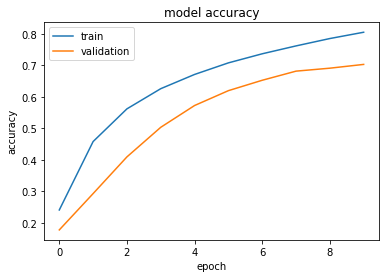

In [ ]:
# Plot model accuracy across epochs for the training and validation sets

import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
# Evaluate the model on test data
print("Evaluate on test data")
results = model_final.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 5s 40ms/step - loss: 0.8974 - accuracy: 0.6945
test loss, test acc: [0.8973769545555115, 0.6945000290870667]
